# **YOGA POSE CLASSIFICATION**

By:

    Anand K S [AM.EN.U4CSE19106]
    Bharath Prathap Nair [AM.EN.U4CSE19113]
    Rahan Manoj [AM.EN.U4CSE19144]

This notebook contains the code used to generate a feed forward model for yoga pose classification.

The dataset is taken from [Kaggle](www.kaggle.com/shrutisaxena/yoga-pose-image-classification-dataset). The creator of the dataset is Shruthi Saxena. 10 classes of yogasanas were taken from this dataset. The dataset also contains images scrapped from google images using a chrome extension.

Also the images were loaded and resized and converted to pixels as well as the details of images like asana-names were extracted from the file path and label encoded and stored in various textfiles so that they can be easily loaded in the future in less time. The text files can be accessed from [here](https://drive.google.com/drive/folders/1_Qj1pXLXdTOh7vAzzq_QQLq6BZItafId)

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


LOADING IMAGES USING OPENCV

In [ ]:
import re
import cv2

labels = []
images = []
asanas_name = []
images_path = []
images_pixels = []

i=0
dataset_path = 'drive/MyDrive/DEEP LEARNING/dataset-2'

for directory in os.listdir(dataset_path):
    asanas_name.append(directory)
    for img in os.listdir(os.path.join(dataset_path,directory)):  
        if len(re.findall('.png',img.lower())) != 0 or len(re.findall('.jpg',img.lower())) != 0 or len(re.findall('.jpeg',img.lower())) != 0:
            img_path = os.path.join(os.path.join(dataset_path,directory),img)
            images.append(img)
            images_path.append(img_path)
            img_pix = cv2.imread(img_path,1)
            images_pixels.append(cv2.resize(img_pix, (128,128)))
            labels.append(i)
        
    i = i+1

    
print("Total labels: ", len(labels))
print("Total images: ", len(images))
print("Total images path: ", len(images_path))
print("Total asanas: ", len(asanas_name))
print("Total images_pixels: ", len(images_pixels))

Total labels:  2793
Total images:  2793
Total images path:  2793
Total asanas:  10
Total images_pixels:  2793


In [ ]:
#TO SAVE THE DATA FROM IMAGES AS TXT FILE INORDER TO SAVE DATA LOADING TIME FOR FUTURE.

import pickle

with open('labels.txt', 'wb') as fp:
    pickle.dump(labels, fp)

with open('images.txt', 'wb') as fp:
    pickle.dump(images, fp)

with open('images_path.txt', 'wb') as fp:
    pickle.dump(images_path, fp)

with open('asanas_name.txt', 'wb') as fp:
    pickle.dump(asanas_name, fp)

with open('images_pixels.txt', 'wb') as fp:
    pickle.dump(images_pixels, fp)

Load the text files in the cell below.

In [ ]:
#LOADING THE SAVED DATA HERE... IGNORE ALL CELLS ABOVE WHILE LOADING AGAIN.

import pickle
with open('/content/drive/MyDrive/asanas_name.txt','rb') as fp:
  asanas_name = pickle.load(fp)

with open('/content/drive/MyDrive/images.txt','rb') as fp:
  images = pickle.load(fp)

with open('/content/drive/MyDrive/images_path.txt','rb') as fp:
  images_path = pickle.load(fp)

with open('/content/drive/MyDrive/labels.txt','rb') as fp:
  label = pickle.load(fp)

with open('/content/drive/MyDrive/images_pixels.txt','rb') as fp:
  img_pixel = pickle.load(fp)





In [ ]:
#NORMALISING PIXEL VALUES BETWEEN 0 and 1

from tqdm import tqdm
for i in tqdm(range(len(img_pixel))):
  img_pixel[i] = img_pixel[i]/255

100%|██████████| 1242/1242 [00:00<00:00, 3038.49it/s]


In [ ]:
# CONVERTING THE IMAGE PIXELS AND LABELS TO  NUMPY ARRAY

X = np.array(img_pixel)
y = np.array(label)
X.shape, y.shape

((1242, 128, 128, 3), (1242,))

TRAIN TEST SPLIT

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 1, stratify=y)
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((745, 128, 128, 3), (745,)), ((497, 128, 128, 3), (497,)))

DATA AUGMENTATION

In [ ]:

from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian

final_train_data = []
final_target_train = []
for i in tqdm(range(X_train.shape[0])):
    final_train_data.append(X_train[i])
    final_train_data.append(rotate(X_train[i], angle=45, mode = 'wrap'))        # Rotating the image by 45 degrees.
    final_train_data.append(rotate(X_train[i], angle=300, mode = 'wrap'))       # Rotating the image by 300 degrees.
    final_train_data.append(np.fliplr(X_train[i]))                              # Flip image left to right [ horizontal flip]
    final_train_data.append(random_noise(X_train[i],var=0.2**2))                # Add noise to the image
    final_train_data.append(gaussian(X_train[i],sigma=1,multichannel=True))     # Blurring the image
    final_train_data.append(X_train[i] + (100/255))                             # Increasing brightness  
    final_train_data.append(X_train[i] * 1.5)                                   # Increasing contrast
    transform = AffineTransform(translation=(25,25))                            # Shearing images.
    final_train_data.append(warp(X_train[i],transform,mode='wrap'))
    for j in range(9):
        final_target_train.append(y_train[i])

100%|██████████| 745/745 [00:16<00:00, 43.95it/s]


In [ ]:
# CONVERTED FINAL TRAIN DATA TO NUMPY AND STORE IN X_train and Labels to y_train

X_train = np.array(final_train_data)
y_train = np.array(final_target_train)
len(X_train), len(y_train)                                                      # Prints the length of the augmented dataset

(6705, 6705)

In [ ]:
X_train.shape

(6705, 128, 128, 3)

In [ ]:
#COnverting numpy arrays to torch.

X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

In [ ]:
X_train = X_train.float()
X_test = X_test.float()


In [ ]:
#CREATING TRAIN LOADER AND TEST LOADER WITH BATCH SIZE - 32 AND SHUFFLING WAS ENABLED TO ENSURE UNIFORMITY.

train_data = []
for i in range(len(X_train)):
   train_data.append([X_train[i], y_train[i]])

test_data = []
for i in range(len(X_test)):
   test_data.append([X_test[i], y_test[i]])

trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=32)


#MODEL CREATION

Here we have used a model with 5 layers which was the best performing model among the various models generated. The best model can be loaded using the model file from the google drive [link](https://drive.google.com/drive/folders/1XBdZDf-_wY32F7qO59RrtRdLik83c8a1) . The model attains a testing accuracy of 70. Loading the model using torch.load is also explained below.

Input Layer dimension = 3 * 128 * 128

First hidden layer dimension = 512 

Second hidden layer dimension = 1024

Third hidden layer dimension  = 512

Output layer dimension  = 10 [ As we have 10 classes]

Also various regularisation parameters like dropout are also used. The activation function for the hidden layer is LeakyReLU and the output activation function is LogSoftmax. He initialisation has also been applied.

In [ ]:

class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.tanh1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        nn.Dropout(p=0.5)
        nn.init.kaiming_normal_(self.fc2.weight)
        self.tanh2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        nn.Dropout(p=0.5)
        nn.init.kaiming_normal_(self.fc3.weight)
        self.tanh3 = nn.LeakyReLU()
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        nn.Dropout(p=0.5)
        nn.init.kaiming_normal_(self.fc4.weight)
        self.softmax = nn.LogSoftmax()
        # self.fc1 = nn.Linear(input_dim, hidden_dim1)
        # self.tanh1 = nn.LeakyReLU()
        # self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        # self.tanh2 = nn.LeakyReLU()
        # self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        # self.tanh3 = nn.LeakyReLU()
        # self.fc4 = nn.Linear(hidden_dim3, output_dim)
        # self.softmax = nn.LogSoftmax()

        
    def forward(self, x):
        out = self.fc1(x)
        out = self.tanh1(out)
        out = self.fc2(out)
        out = self.tanh2(out)
        out = self.fc3(out)
        out = self.tanh3(out)
        out = self.fc4(out)
        out = self.softmax(out)
        return out


In [ ]:
input_dim = 3*128*128
hidden_dim1 = 512
hidden_dim2 = 1024
hidden_dim3 = 512
output_dim = 10

In [ ]:
model = FeedforwardNeuralNetModel(input_dim, hidden_dim1,hidden_dim2,hidden_dim3, output_dim)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # To enable GPU.
model.to(device)

FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=49152, out_features=512, bias=True)
  (tanh1): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=512, out_features=1024, bias=True)
  (tanh2): LeakyReLU(negative_slope=0.01)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (tanh3): LeakyReLU(negative_slope=0.01)
  (fc4): Linear(in_features=512, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=None)
)

DEFINING THE OPTIMISER

In [ ]:
#Uncomment the loss function in use at the time of running.

criterion = nn.NLLLoss()
#criterion = nn.CrossEntropyLoss()

learning_rate = 0.001

# Note : During testing phase, the required optimizers were set here.
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay = 0.01)

In [ ]:
train_losses = []
train_acc = []
test_losses = []
test_acc = []
iter = 0

for epoch in range(30):                                                         # 30 is the number of epochs
    train_correct = 0
    total1 = 0
    running_loss = 0
    for images, labels in trainloader:                                          # Training
        images = images.view(-1, 3*128*128).requires_grad_().to(device)         # reshaping image to 2-D for training.
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total1 += labels.size(0)
        if torch.cuda.is_available():
            train_correct += (predicted.cpu() == labels.cpu()).sum()
        else:
            train_correct += (predicted == labels).sum()

    train_accuracy = 100 * train_correct / total1
    train_loss = running_loss/len(trainloader)
    train_acc.append(train_accuracy)
    train_losses.append(train_loss)

    test_loss = 0
    correct = 0
    total = 0
    for images, labels in testloader:                                           # Testing
        images = images.view(-1, 3*128*128).requires_grad_().to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss_t = criterion(outputs,labels)
        test_loss += loss_t.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        if torch.cuda.is_available():
            correct += (predicted.cpu() == labels.cpu()).sum()
        else:
            correct += (predicted == labels).sum()

    test_loss=test_loss/len(testloader)
    accuracy = 100 * correct / total
    test_acc.append(accuracy)
    test_losses.append(test_loss)
    print('Epoch: {} - loss: {} - accuracy: {} - val_Loss: {} - val_accuracy: {}'.format(epoch+1, train_loss, train_accuracy, test_loss, accuracy))        
            

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 - loss: 9.397630112511772 - accuracy: 21.98359489440918 - val_Loss: 1.9279841184616089 - val_accuracy: 32.997989654541016
Epoch: 2 - loss: 1.86300368309021 - accuracy: 38.09097671508789 - val_Loss: 1.8192869126796722 - val_accuracy: 35.01005935668945
Epoch: 3 - loss: 1.6635478786059787 - accuracy: 44.50410079956055 - val_Loss: 1.9723844155669212 - val_accuracy: 30.5835018157959
Epoch: 4 - loss: 1.5522618075211843 - accuracy: 48.79940414428711 - val_Loss: 1.5397832840681076 - val_accuracy: 51.10663986206055
Epoch: 5 - loss: 1.4502213557561239 - accuracy: 52.42356491088867 - val_Loss: 1.3558175191283226 - val_accuracy: 61.77062225341797
Epoch: 6 - loss: 1.3738894669782549 - accuracy: 54.67561340332031 - val_Loss: 1.411745022982359 - val_accuracy: 54.32595443725586
Epoch: 7 - loss: 1.3104853456928616 - accuracy: 56.83818054199219 - val_Loss: 1.3910571113228798 - val_accuracy: 57.94768524169922
Epoch: 8 - loss: 1.2561345344498045 - accuracy: 59.47800064086914 - val_Loss: 1.2584841

In [ ]:
#This was used for saving the best model.

torch.save(model,'model2(83,70)')

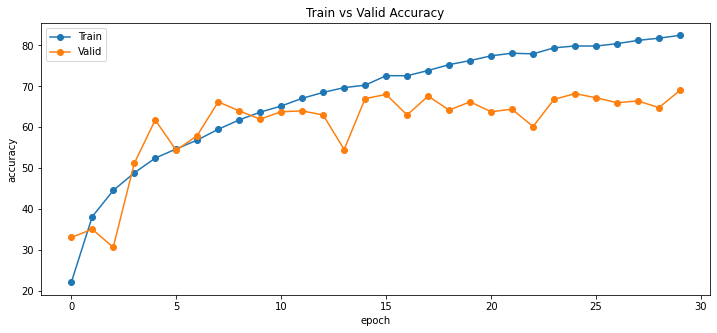

In [ ]:
# PLOTTING TRAIN-TEST ACCURACY PLOT 

fig = plt.figure(figsize=(12,5))
plt.plot(train_acc,'-o')
plt.plot(test_acc,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
 
plt.show()

In [ ]:
fig.savefig("model_accuracy_graph.pdf")                                         # Saving image to pdf for documentation.  

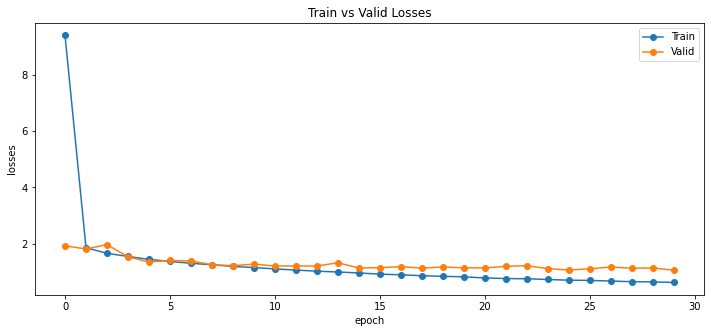

In [ ]:
# PLOTTING TRAIN-TEST LOSS GRAPH

fig = plt.figure(figsize=(12,5))
plt.plot(train_losses,'-o')
plt.plot(test_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
 
plt.show()

In [ ]:
fig.savefig("mode_loss_graph.pdf")

LOADING THE SAVED GOOD MODEL FOR TESTING


Load the model from [here](https://drive.google.com/drive/folders/1XBdZDf-_wY32F7qO59RrtRdLik83c8a1)

In [ ]:
model = torch.load('/content/drive/MyDrive/model2(83,70)')

VERIFYING THE ACCURACY OF THE LOADED MODEL USING TEST DATA

In [ ]:
test_loss = 0
correct = 0
total = 0

for images, labels in testloader:
        images = images.view(-1, 3*128*128).requires_grad_().to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss_t = criterion(outputs,labels)
        test_loss += loss_t.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        if torch.cuda.is_available():
            correct += (predicted.cpu() == labels.cpu()).sum()
        else:
            correct += (predicted == labels).sum()

test_loss=test_loss/len(testloader)
accuracy = 100 * correct / total
print(accuracy)

tensor(70.6237)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
model.eval()

FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=49152, out_features=512, bias=True)
  (tanh1): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=512, out_features=1024, bias=True)
  (tanh2): LeakyReLU(negative_slope=0.01)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (tanh3): LeakyReLU(negative_slope=0.01)
  (fc4): Linear(in_features=512, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=None)
)

The predict function is the function for prediction using the loaded model. The function performs all the pre-processing steps for a single image and predicts its output using the model.

In [ ]:
def predict(img):
  img = cv2.resize(img, (128,128))
  img = img/255
  img = np.array(img)
  img = torch.from_numpy(img)
  img = img.float()
  img = img.view(-1, 3*128*128).to(device)
  outputs = model(img)
  _, predicted = torch.max(outputs.data, 1)
  return asanas_name[predicted]

TESTING ON RANDOM IMAGE

ACTUAL - BHUJANGASANAM
PREDCITION :  BHUJANGASANA


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


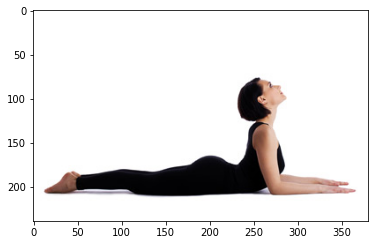

In [ ]:
print("ACTUAL - BHUJANGASANAM")
img = cv2.imread('/content/drive/MyDrive/bhujangasanam.jpg')
print("PREDCITION : ",predict(img).upper())
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

ACTUAL - SAVASANA
PREDCITION :  SAVASANA


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


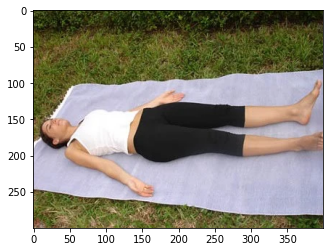

In [ ]:
print("ACTUAL - SAVASANA")
img = cv2.imread('/content/drive/MyDrive/savanasana.jpeg')
print("PREDCITION : ",predict(img).upper())
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))